# Introduction

I have been tasked with investigating tweet content and sentiment within this dataset. I believe time series may be a useful tool in this analysis as we are given a time series column with exact information regarding timestamps. The analysis objective will be to gain more information about peoples tweeting habits and how we can predict these, so that in the future we can pre-empt when customers might tweet good or bad things. We could also use this for promotional offers, as more tweet traffic would also mean more interaction with our twitter profile and the content on it.

 I will use the SARIMA time series model as well as topic modelling by using Latent Dirichlet Allocation. I will also perform sentinment analysis, I will use two classification algorithms for this, random forest and naive bayes.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df['tweet_created'].nunique()

14247

In [5]:
df["tweet_id"].nunique()

14485

In [6]:
df.shape

(14640, 15)

In [7]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [8]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
df.duplicated().sum()

36

In [10]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

I wanted to check the overall correlation of airline sentiment and how this related to the other features in the dataset. As well as show the kernel density, to understand where the majority of these values lie to gain a deeper understanding of how my models will work. 

One interesting obervsation from this graph is that positive and neutral classified sentiment seem to be overlapping quite a bit with negative correlation forming it's own category. 

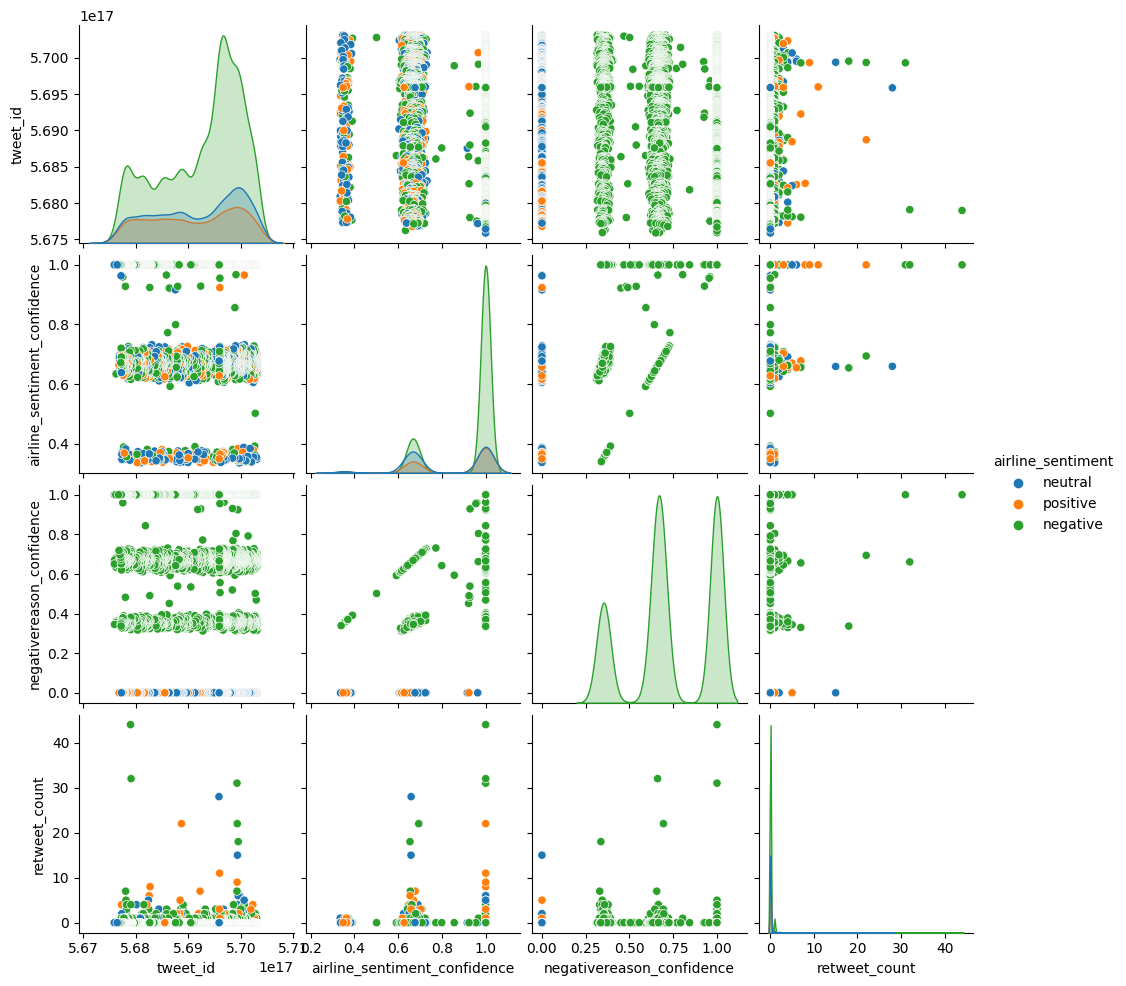

In [11]:
sns.pairplot(df,hue='airline_sentiment')

In [12]:
# dropping columns with lots of missing values 
df1=df.drop(["airline_sentiment_gold","negativereason_gold","tweet_coord","tweet_location","user_timezone"], axis=1)

In [13]:
df1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


In [14]:
df1.dtypes


tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
name                             object
retweet_count                     int64
text                             object
tweet_created                    object
dtype: object

# Data preparation

I will now prepare the data for time series analysis and perform an investigation as to which model will be appropriate for this analysis.

Among these tests will be the dicky fuller test which searches for stationarity in the dataset. (Verma) as well as auto correlation and partial auto correlation. These will help me determine my model choice.

In [15]:
df1["Date"] = df1["tweet_created"].astype("datetime64")


In [16]:
df1.dtypes

tweet_id                                 int64
airline_sentiment                       object
airline_sentiment_confidence           float64
negativereason                          object
negativereason_confidence              float64
airline                                 object
name                                    object
retweet_count                            int64
text                                    object
tweet_created                           object
Date                            datetime64[ns]
dtype: object

In [17]:
df1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,Date
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,2015-02-24 19:35:52
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,2015-02-24 19:15:59
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,2015-02-24 19:15:48
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,2015-02-24 19:15:36
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,2015-02-24 19:14:45


In [18]:
min_time = df1["Date"].min()
max_time = df1["Date"].max()
print ("Min time: ", min_time )
print ("Max time: ", max_time)

Min time:  2015-02-17 07:36:05
Max time:  2015-02-24 19:53:37


In [19]:
#dropping columns that are not relevant to the investigation. 
dftimeseries = df1.drop(["airline_sentiment","negativereason","airline","name","text","retweet_count","tweet_created" ,"negativereason_confidence","airline_sentiment_confidence"], axis=1)

In [20]:
#preliminary dataset for time series analysis
dftimeseries.head()

,tweet_id,Date
0,570306133677760513,2015-02-24 19:35:52
1,570301130888122368,2015-02-24 19:15:59
2,570301083672813571,2015-02-24 19:15:48
3,570301031407624196,2015-02-24 19:15:36
4,570300817074462722,2015-02-24 19:14:45


In [21]:
dftimeseries.shape

(14640, 2)

I have created a subset that looks at the frequency of tweets, and when they have taken place. I will use this as the basis for my time series analysis. 

In [22]:
tweetfreq = pd.crosstab(index=dftimeseries["Date"],columns='count')


In [23]:
tweetfreq.head()

col_0,count
Date,
2015-02-17 07:36:05,1
2015-02-17 07:43:02,1
2015-02-17 07:48:48,1
2015-02-17 07:52:20,1
2015-02-17 08:00:36,1


We can see that there is a spike in the frequency of tweet that happen during the end of the week. This would suggest some sort of weekly seasonality as people would be more active during the weekend. 

<Axes: xlabel='Date'>

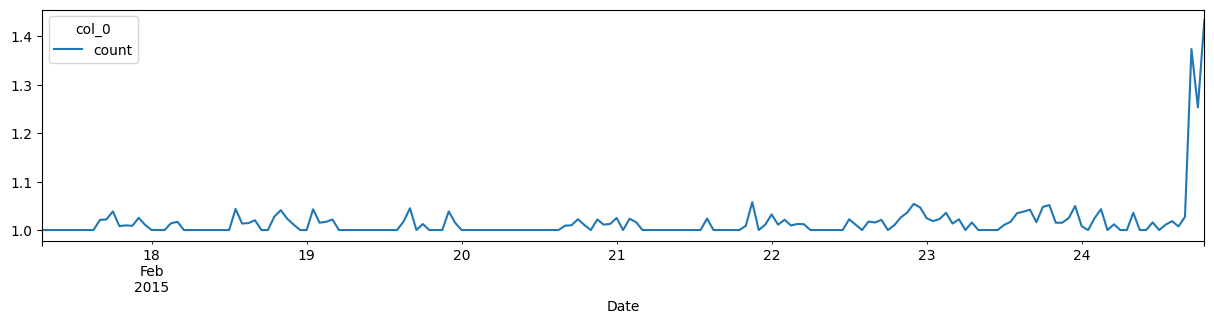

In [24]:
tweetfreq.resample(rule='H').mean().plot(y=["count"],figsize=(15,3))

In [25]:
tweetfreq2 = tweetfreq.resample(rule='H').mean()

In [26]:
tweetfreq2.head()


col_0,count
Date,
2015-02-17 07:00:00,1.0
2015-02-17 08:00:00,1.0
2015-02-17 09:00:00,1.0
2015-02-17 10:00:00,1.0
2015-02-17 11:00:00,1.0


In [27]:
tweetfreq2.shape

(181, 1)

# SARIMA Model - data understanding and parameter tuning

I have used the dickey fuller test and plotted both autocorrelation and partial auto correlation graphs. The dickey fuller test, tests the null hypothesis of the unit root, to see if the data is stationary. The P value being 0.99 and the autocorrelation and partial autocorrelation suggests a seasonal relationship, or non-stationary data. So we will need to seek the d parameter. This may be because of the spike of tweets on the weekend. This presents a slight issue, as most of the data is uniform, however the spike of tweets on the weekend will cause an unauthentic relationship. We need to be able to predict this spike each week.

The autocorrelation shows a value of 3, and partial auto correlation shows a value of 2. So our p and q values will be 2 and 3. (Verma, 2022)

I will use auto arima to find optimal parameters for P, Q and D. I am doing this because it should give accurate results and takes into account all iterations of the data. 


My approach to this will be to use a SARIMA model, which handles seasonality, in this case weekly. and to take some of the training data to incorporate this spike.

In [28]:
adfuller(tweetfreq2["count"])

(2.503263672850365,
 0.9990508953712681,
 1,
 179,
 {'1%': -3.4674201432469816,
  '5%': -2.877826051844538,
  '10%': -2.575452082332012},
 -663.0453623854473)

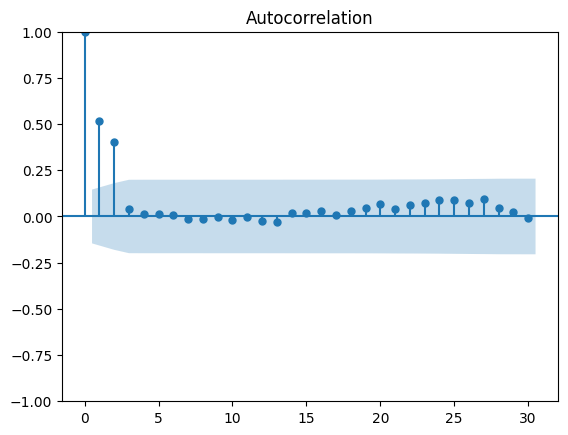

In [29]:
#auto correlation
plot_acf(tweetfreq2["count"], lags=30);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


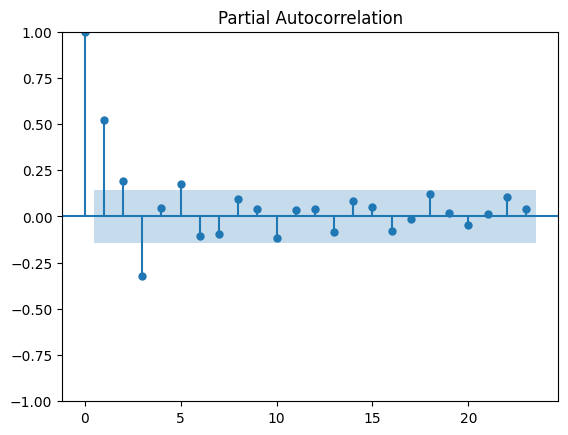

In [30]:
#partial autocorrelation
plot_pacf(tweetfreq2["count"]);

In [31]:
#taking 85% of the data for training
train = tweetfreq2[:int((0.85)*len(tweetfreq2))]
test = tweetfreq2[int((0.85)*len(tweetfreq2)):]

In [32]:
train.shape

(153, 1)

In [33]:
test.shape

(28, 1)

In [34]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.0 MB/s eta 0:00:00


I have chosen my M parameter based on the date time series information in the dataset. The parameter ' M ' in SARIMA is the amount of steps in a seasonal period. In this case, that is 7 days. using auto arima to find the optimal parameters for P, D and Q as well as using auto and partial autocorrelation has led me to the parameters of p=2, d=0, q=3, P=2, D=1, Q=0 and M=7.

With regards to validation, I opted for a simple train test split of 85% training data and 15% testing data. This was done by spliting the length of the dataset as time series training and testing must be done in order, to retain the shape of the data. 

In [35]:



from pmdarima.arima import auto_arima
arima_model=auto_arima(train,start_p=0,d=0,start_q=0,max_p=5,max_d=5,max_q=5,start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=7,seasonal=True,error_action="warn",trace=True,supress_warnings=True,stepwise=True,random_state=42,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-751.538, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-797.441, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-753.330, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-772.921, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=-831.514, Time=1.51 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=-829.545, Time=6.58 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=-829.351, Time=4.49 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(1,0,0)(3,1,1)[7] intercept   : AIC=-827.516, Time=3.23 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=-819.891, Time=1.06 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=-829.711, Time=4.54 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=-829.680, Time=3.91 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=-829.947, Time=3.17 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=-

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(2, 0, 3), seasonal_order=(2, 1, 0, 7)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In our model summary, we can see that the normal Q-Q graph shows that most of the theoretical quartiles are on the mean line but it is not perfect by any means. Let's plot the graph and see our results.

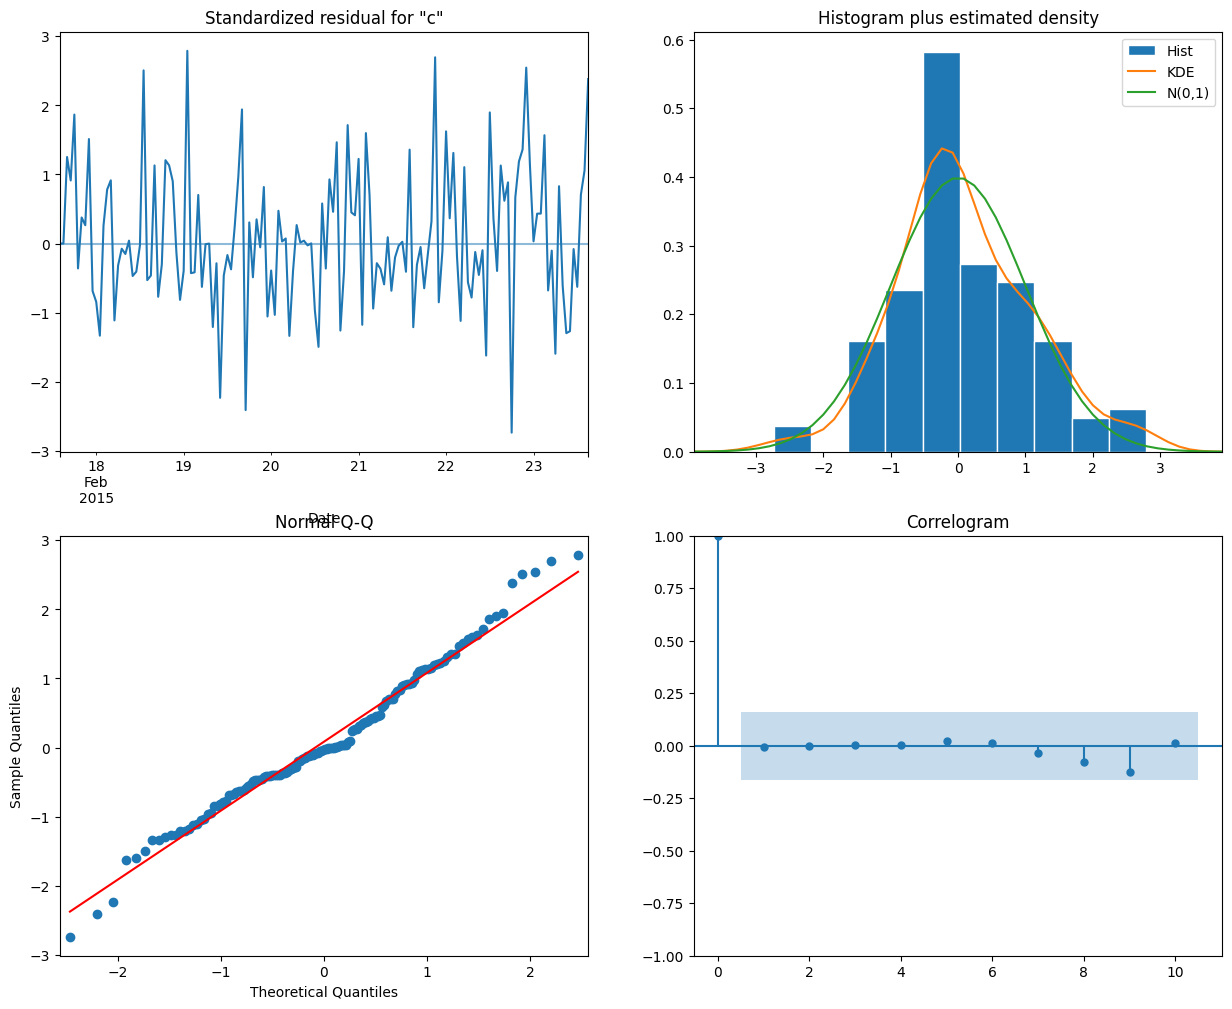

In [37]:
model.plot_diagnostics(figsize=(15, 12));

In [38]:
start = len(train)
end = len(train) + len(test) -1
tmodel = model.predict(start=start, end=end).rename("SARIMA Predictions")

#Model results and forecast

This graph shows our prediction set against our test set. It should be noted that the data was split to perform training and testing. We can see that we get a decent prediction however the model is failing to pick up the spike at the end of the week.

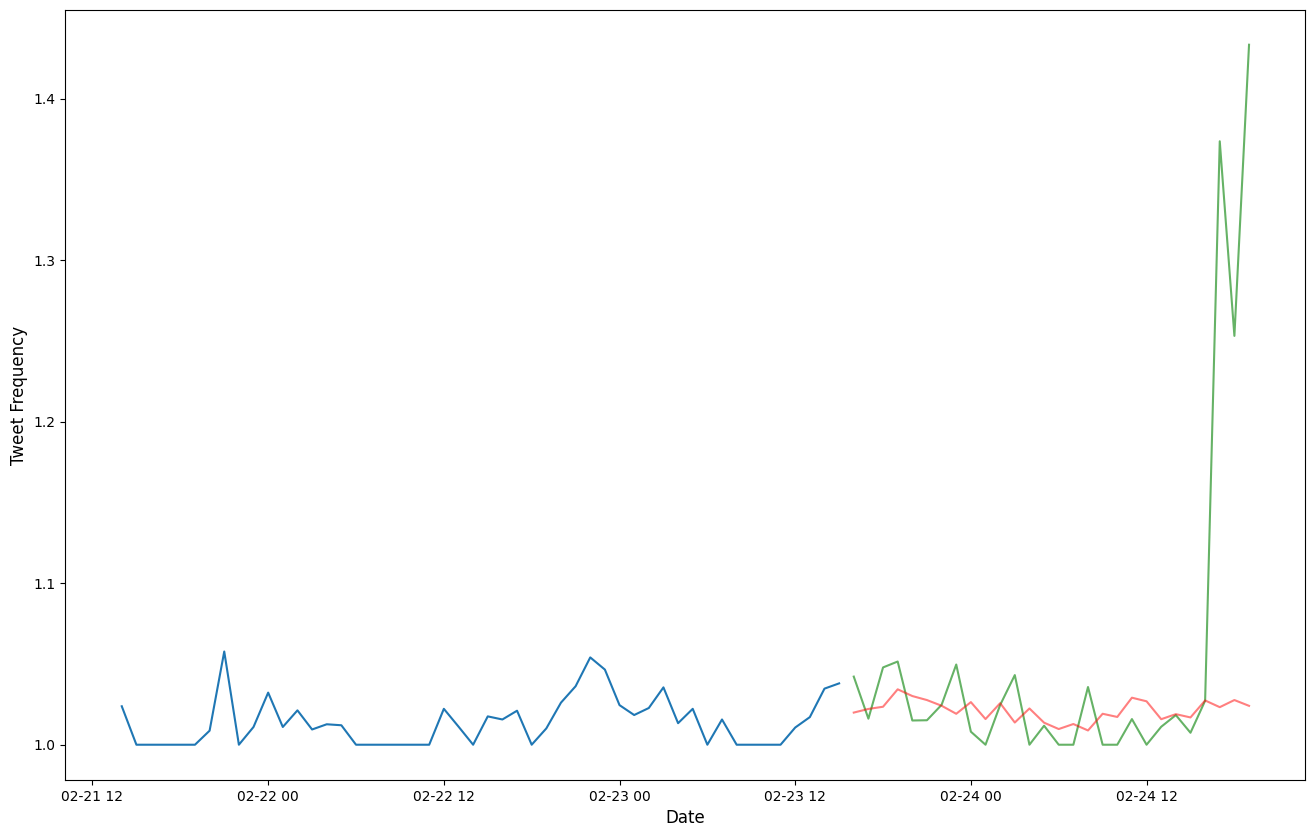

In [39]:
plt.figure(figsize = [16, 10])
plt.plot(train["count"].iloc[-50:])
plt.plot(test["count"], color="green", alpha=0.6)
plt.plot(tmodel, color="red", alpha=0.5,)

plt.xlabel("Date", fontsize = 12)
plt.ylabel("Tweet Frequency", fontsize = 12)


plt.show()

In [40]:
forecast_values = model.get_forecast(steps= 100)
forecast_ci = forecast_values.conf_int()

forecast_ci.head()

,lower count,upper count
2015-02-23 16:00:00,0.993843,1.045954
2015-02-23 17:00:00,0.994835,1.049462
2015-02-23 18:00:00,0.996035,1.050978
2015-02-23 19:00:00,1.006664,1.061943
2015-02-23 20:00:00,1.002493,1.057783


We can see that our one week prediction reflects the original prediction result against the training and testing set. Overall, it is not a bad result but it fails to pick up the sharp increase in tweet frequency over the weekend. The yellow represents the confidence interval that the real value could lie within that range. Over time, this increases as there would be more unknown factors in the new data. 

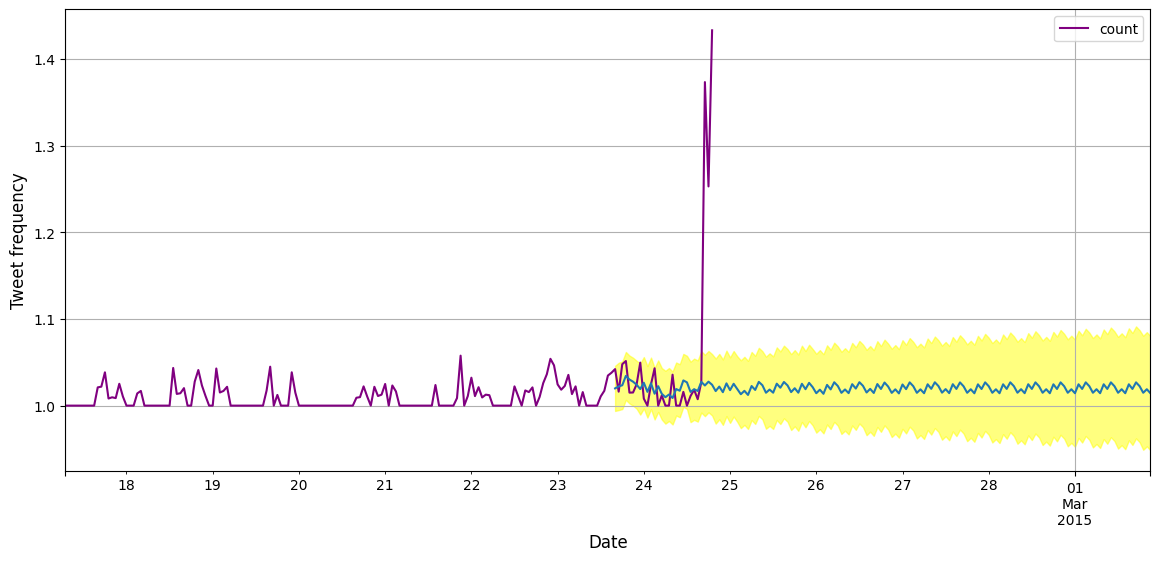

In [41]:
forecast_values = model.get_forecast(steps= 150)
forecast_ci = forecast_values.conf_int()

ax = tweetfreq2.plot(y = "count" , legend=True, color="purple", figsize=(14, 6))

forecast_values.predicted_mean.plot(ax = ax, label="Forecast", grid=True)

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1],
                color="yellow", alpha=0.5
               )

plt.xlabel("Date", fontsize = 12)
plt.ylabel("Tweet frequency", fontsize = 12)



plt.show()

# Results and conclusions

Overall the SARIMAX model performed satisfactorily, however it failed to pick up the spike in tweet frequency over the weekend. The main limitation I see in this dataset is the size of it. It would be possible to get more accurate results and portray more authentic seasonality with a larger dataset that could find the trends of tweet frequency easier as it changes between weekday and weekend. 

# Topic modeling and sentiment analysis

The next part of this project is to perform text analysis in the form of topic modeling and sentiment analysis to this dataset. I will first do some invesitgation regarding sentiment and topics to gain a better understanding of the data.

I believe text analysis will be useful because it will give us more information as to what customers are saying within their tweets, both negative and positive. This can help us identify areas we need to improve in as well as areas we can continue to do well in, and perhaps further improve on. 

We can also use this to see what these improvements could be. 



 I wanted to gain more information regarding the sentiment of each tweet and how it related to each airline. With this information it is possible to learn from other airlines reviews on twitter and improve upon it for your own company. We will look more at exactly what contributes to the sentiment within these tweets.

<Axes: xlabel='airline'>

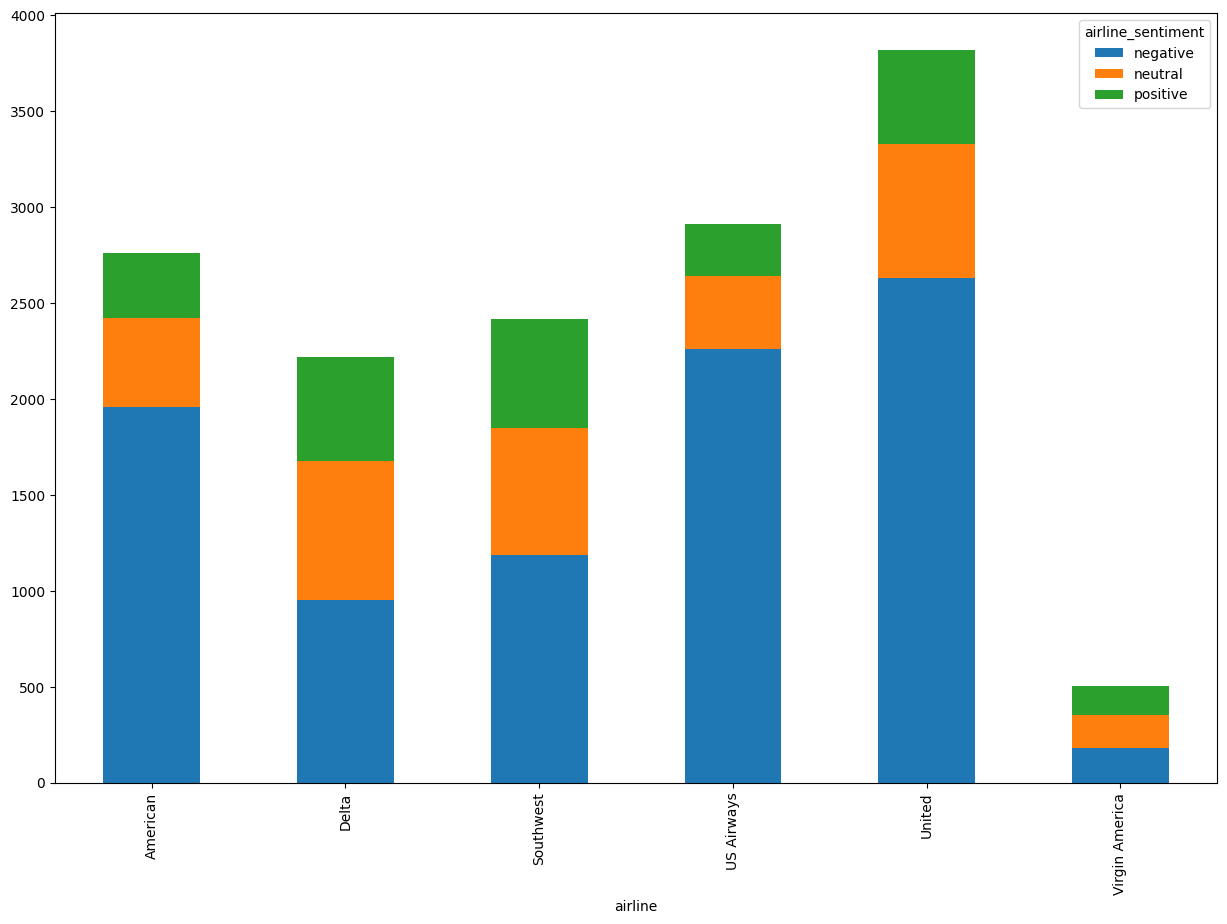

In [42]:
figure_2 = df.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(15,10))

The below graph gives us a bit more information regarding the "why" of the airline sentiment. We can see that most of the negative reasons were due to a customer service issue. This strengthens teh justification for topic modelling to spot what issues customers have with our staff.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


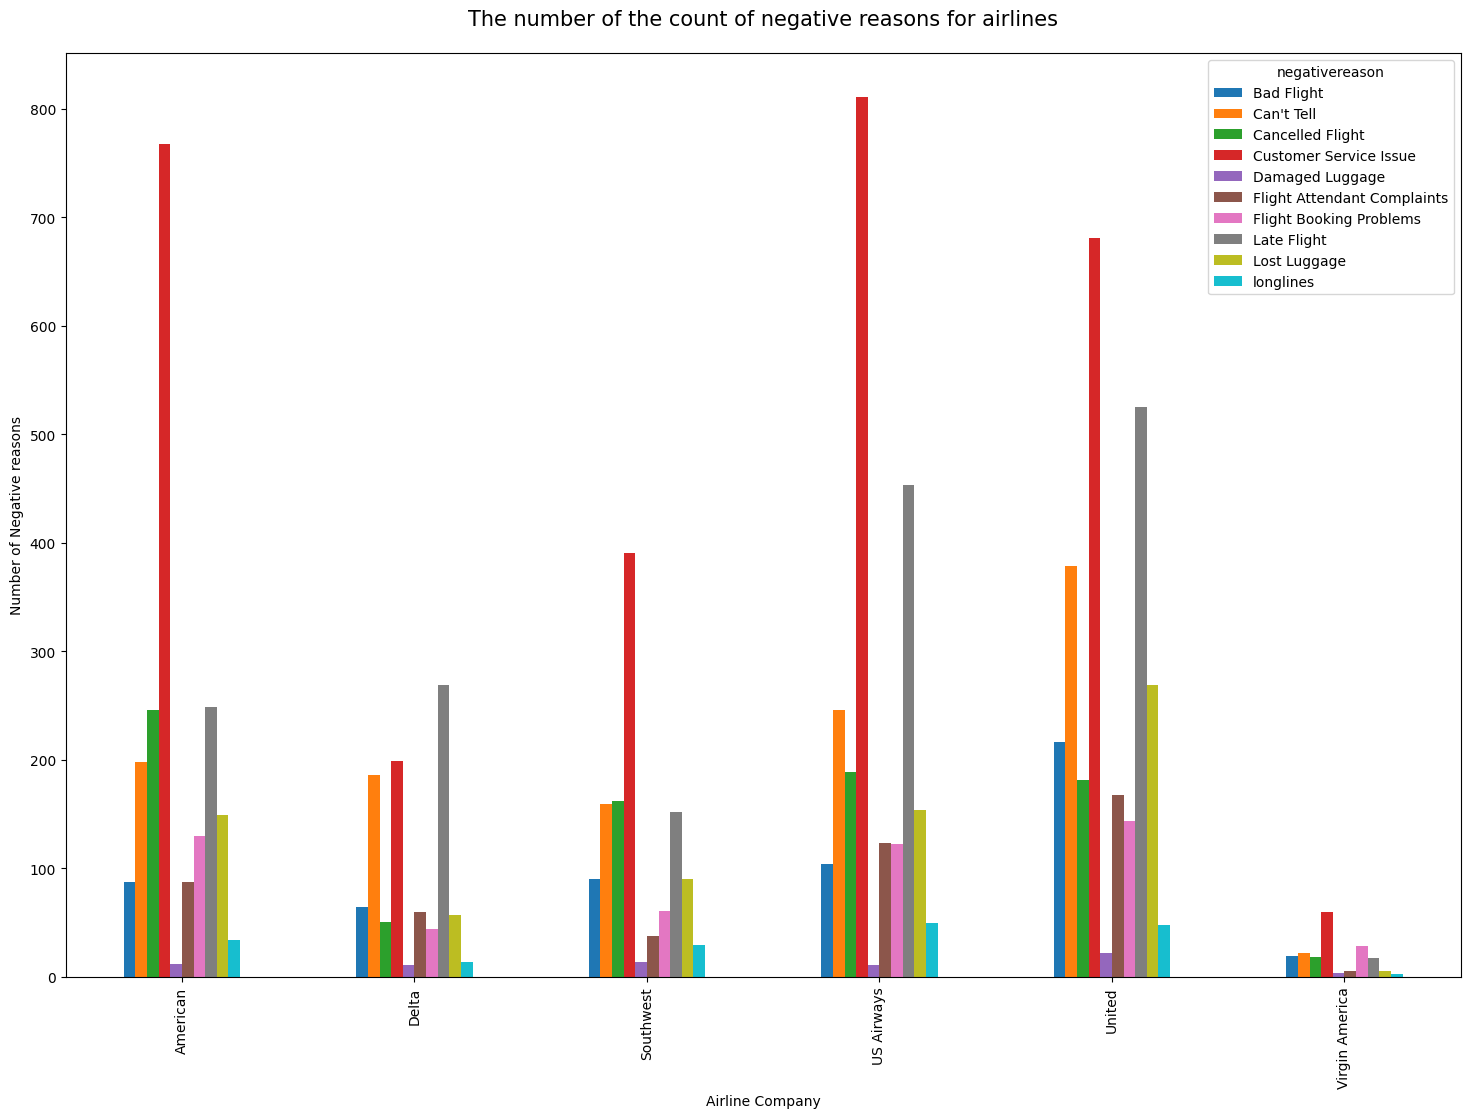

In [131]:
negative_reasons = df.groupby('airline')['negativereason'].value_counts(ascending=True)
negative_reasons.groupby(['airline','negativereason']).sum().unstack().plot(kind='bar',figsize=(18,12))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines", pad=20, fontsize = 15)
plt.show()

In [44]:
date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()

day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

The below graph shows negative tweets per day related to each airline. What is interesting is that more tweets appear on the weekend. This would make sense as our tweet frequency was more during the weekend also. 

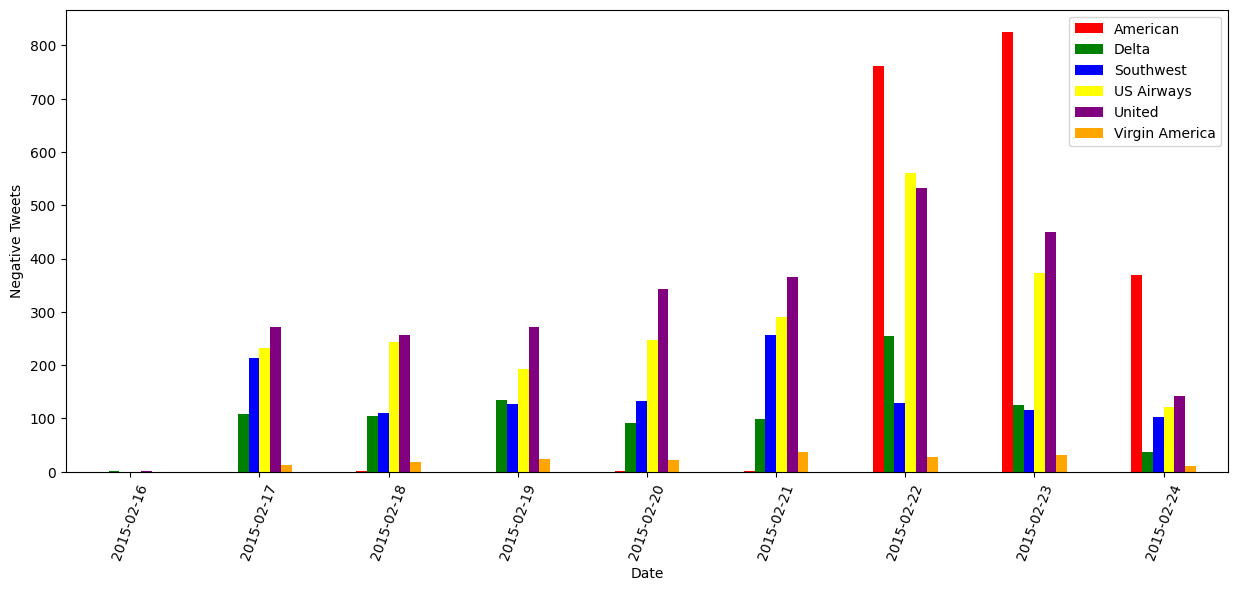

In [45]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

In [46]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


#Topic Modelling

Topic modelling is a statistical modelling type that uses unsupervised learning to identify clusters of similar words within a text pool. In this case, our text pool would be the "text" column of this dataset.(“What Is Topic Modeling? A Beginner’s Guide”) 

 This will tell me what words or "topics" are most used in the tweets. I will perform a wordcloud for both positive and negative reasons related to airline sentiment. 

In [48]:
# used for the LDA
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

# Used for the stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from pprint import pprint

# Used for LDA vis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


below is a wordcloud of all the most commonly appearing words that have been classified with both a negative and positive sentiment. I am doing this to get a brief view at the most commonly appearing words in the dataset. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


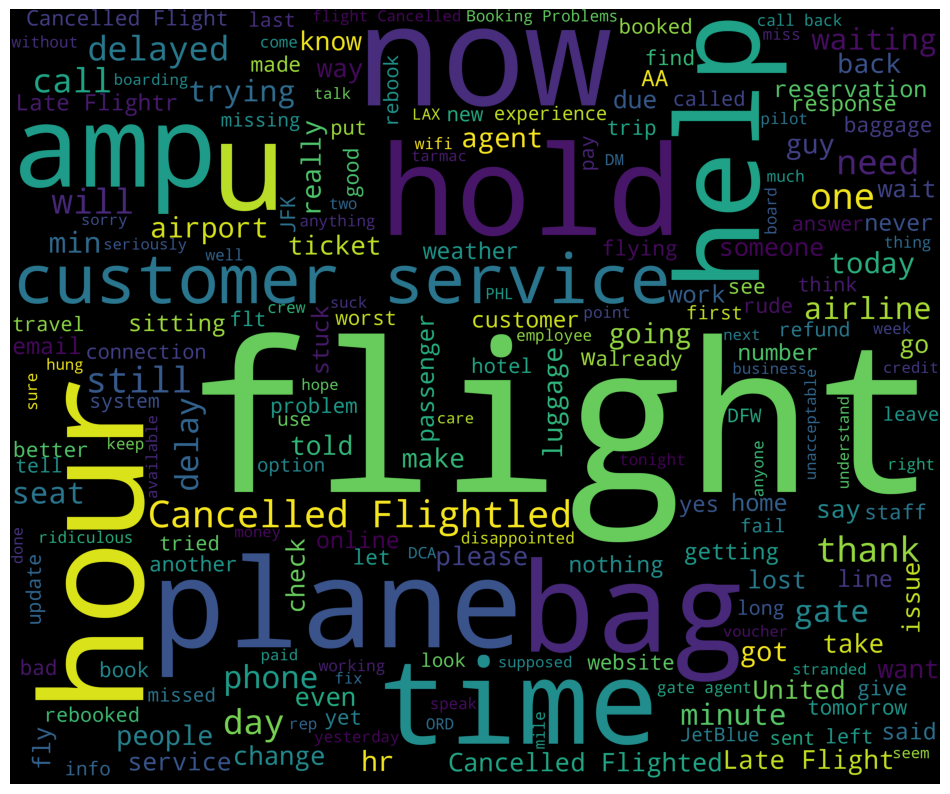

In [49]:
from wordcloud import WordCloud,STOPWORDS
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


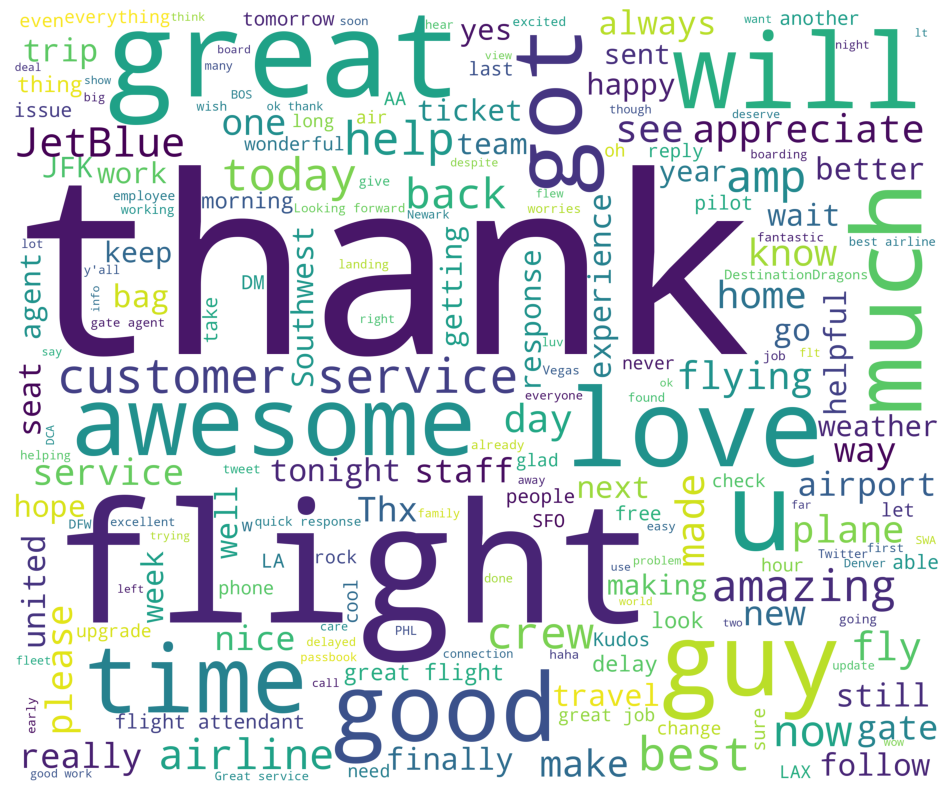

In [50]:
from wordcloud import WordCloud,STOPWORDS
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [51]:
stop_words = stopwords.words('english')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# creating a definition that turns sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
#removing stopwords from the text 
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
texts = df['text'].values.tolist()
words = list(sent_to_words(texts))
words = remove_stopwords(words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
id2words = corpora.Dictionary(words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
corpus = [id2words.doc2bow(text) for text in words]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
num_topics = 20

lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2words,
    num_topics=num_topics,
    random_state=42
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
!pip install "pandas<2.0.0" # use this if LDAvis is not working correctly

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.1
    Uninstalling pandas-2.0.1:
      Successfully uninstalled pandas-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [59]:
LDAvis_prepared = pyLDAvis.gensim.prepare(
    lda_model,
    corpus,
    id2words
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The below graph shows all of the topics that are deemed most relevant by this model within this dataset. These topics are arrangeed into clusters. Clicking on each cluster, or topic,  shows the words in that topic and also the frequency of those words in the selected topic, compared to the overall count of that word within all topics. 

This gives us a better understanding of what people are talking about on twitter. This could give the company a better understanding of predicting or identifying larger issues within the company to improve customer service. 

In [60]:
# topic modelling
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.071425 -0.077642       1        1  9.089992
13    -0.116649  0.032454       2        1  8.824788
8     -0.071027  0.044388       3        1  8.816455
12     0.010131  0.044989       4        1  6.421070
11    -0.091201 -0.030867       5        1  6.260945
14    -0.052022 -0.016415       6        1  6.117371
15    -0.080400 -0.014143       7        1  5.803255
7     -0.002209 -0.001217       8        1  5.553910
5     -0.051457 -0.047365       9        1  5.497651
3     -0.071594  0.057526      10        1  4.501900
19    -0.039416  0.063100      11        1  4.501443
16    -0.086229 -0.040925      12        1  4.070910
1      0.000191  0.040068      13        1  3.743759
6      0.060396  0.004595      14        1  3.644801
4      0.060236 -0.117918      15        1  3.296169
18     0.065432  0.075449      16        1  3.189333
2      0.112399  0.026466      17        1  3.059730
0      0.133633 -0.155964      18        1  2.681588
10     0.144327  0.056391      19        1  2.584332
17     0.146885  0.057032      20        1  2.340597, topic_info=              Term         Freq        Total Category  logprob  loglift
1270   americanair  7960.000000  7960.000000  Default  30.0000  30.0000
440        jetblue  1492.000000  1492.000000  Default  29.0000  29.0000
3007     usairways  3187.000000  3187.000000  Default  28.0000  28.0000
2561            aa   870.000000   870.000000  Default  27.0000  27.0000
28          flight  4070.000000  4070.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
39             fly    19.128445   314.963981  Topic20  -5.1852   0.9535
3280       sending    14.189004    49.391621  Topic20  -5.4839   2.5075
441   southwestair    18.042554   874.456106  Topic20  -5.2437  -0.1261
46              co    16.901674   990.160342  Topic20  -5.3090  -0.3157
90            http    16.839687   954.355599  Topic20  -5.3127  -0.2825

[1443 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2561      1  0.001149    aa
2561      5  0.285006    aa
2561      6  0.128712    aa
2561      7  0.172382    aa
2561     11  0.402226    aa
...     ...       ...   ...
2045     16  0.358527  zero
2045     17  0.056610  zero
2045     19  0.037740  zero
7174     20  0.589094  zoom
6610     20  0.948051    zr

[5345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 14, 9, 13, 12, 15, 16, 8, 6, 4, 20, 17, 2, 7, 5, 19, 3, 1, 11, 18])

In [61]:
import re
from mlxtend.plotting import plot_confusion_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Sentiment analysis

I will now perform sentiment analysis, using a machine learning approach, as the data already has pre-labeled sentiment.

 I will also gain the compound scores of each tweet using the sentiment intensity analyzer, as this can give more detailed information regarding the sentiment of the text. I will also prepare the data to make it suitable for machine learning. This will involve cleaning the tweets of any characters that are not alphabetical. For the machine learning itself,  I have chosen random forest classifier and naive bayes classifer as this is a multiclass classification problem and this models work well for multiclass classification. This is because the sentiment is divided into 3 categories, negative, positive and neutral. These algorithms are good for multiclass classification. (Brownlee)

I will now preprocess the data and clean the information in the text column to prepare it for machine learning. 

In [62]:
#turning tweet to words
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
#getting the meaningful words from tweets
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
#turning sentiment to 1 or 0
df1['sentiment']=df1['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
#importing training libraries
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
#creating 2 columns from the text column with 
df1['clean_tweet']=df1['text'].apply(lambda x: tweet_to_words(x))
df1['Tweet_length']=df1['text'].apply(lambda x: clean_tweet_length(x))
train,test = train_test_split(df1,test_size=0.2,random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
#creating training and testing sets
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
# importing sentiment intenstiy analyzer to to find compound scores
from nltk.sentiment import SentimentIntensityAnalyzer
import statistics
nltk.download('vader_lexicon')
nltk.download('punkt')
sia = SentimentIntensityAnalyzer()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [69]:
def compound_score(text):
    scores = [sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(text)]
    return statistics.mean(scores)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
compound_score(df1['clean_tweet'][5])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.624

In [71]:
df1["Compound_Scores"] = [compound_score(text) for text in df1['clean_tweet']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
df1.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,Date,sentiment,clean_tweet,Tweet_length,Compound_Scores
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,2015-02-24 19:35:52,1,virginamerica dhepburn said,3,0.0000
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,2015-02-24 19:15:59,1,virginamerica plus added commercials experienc...,6,0.0000
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,2015-02-24 19:15:48,1,virginamerica today must mean need take anothe...,8,0.0000
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,2015-02-24 19:15:36,0,virginamerica really aggressive blast obnoxiou...,11,-0.3306
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,2015-02-24 19:14:45,0,virginamerica really big bad thing,5,-0.5829
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,2015-02-24 19:14:33,0,virginamerica seriously would pay flight seats...,12,-0.6240
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,2015-02-24 19:13:57,1,virginamerica yes nearly every time fly vx ear...,11,0.4019
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,pilot,0,@VirginAmerica Really missed a prime opportuni...,2015-02-24 11:12:29 -0800,2015-02-24 19:12:29,1,virginamerica really missed prime opportunity ...,13,0.1458
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,dhepburn,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",2015-02-24 11:11:19 -0800,2015-02-24 19:11:19,1,virginamerica well,2,0.2732
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,YupitsTate,0,"@VirginAmerica it was amazing, and arrived an ...",2015-02-24 10:53:27 -0800,2015-02-24 18:53:27,1,virginamerica amazing arrived hour early good,6,0.7717


In [73]:
#performing feature extraction
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
#importing models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
Classifiers = [ RandomForestClassifier(n_estimators=200), GaussianNB()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#  Results 

We can see from the below classification reports that the random forest algorithm performs well here but the naive bayes does not. The random forest classifier is showing an overall accuracy of 0.76 while naive bayes is only 0.48. In this case, it would be my clear recommendation to use the random forest classifier going forward in this project. 
This may be because random forest is more suited to handling multiclass classification for smaller datasets than naive bayes. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy of RandomForestClassifier is 0.7691256830601093
              precision    recall  f1-score   support

    negative       0.91      0.82      0.86      2104
     neutral       0.45      0.58      0.51       451
    positive       0.60      0.74      0.66       373

    accuracy                           0.77      2928
   macro avg       0.65      0.71      0.68      2928
weighted avg       0.80      0.77      0.78      2928



<Figure size 640x480 with 0 Axes>

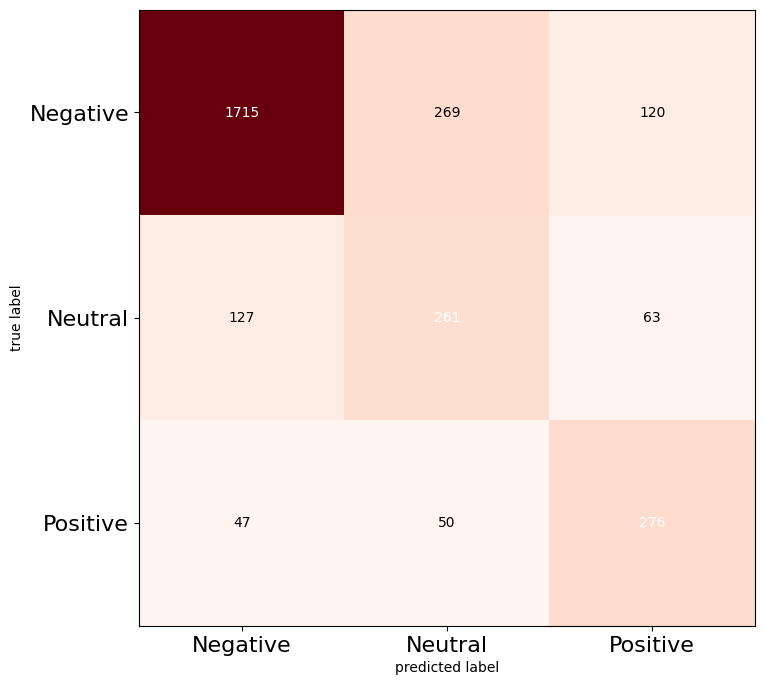

Accuracy of GaussianNB is 0.48941256830601093
              precision    recall  f1-score   support

    negative       0.51      0.81      0.62      1190
     neutral       0.30      0.28      0.29       621
    positive       0.65      0.27      0.38      1117

    accuracy                           0.49      2928
   macro avg       0.49      0.45      0.43      2928
weighted avg       0.52      0.49      0.46      2928



<Figure size 640x480 with 0 Axes>

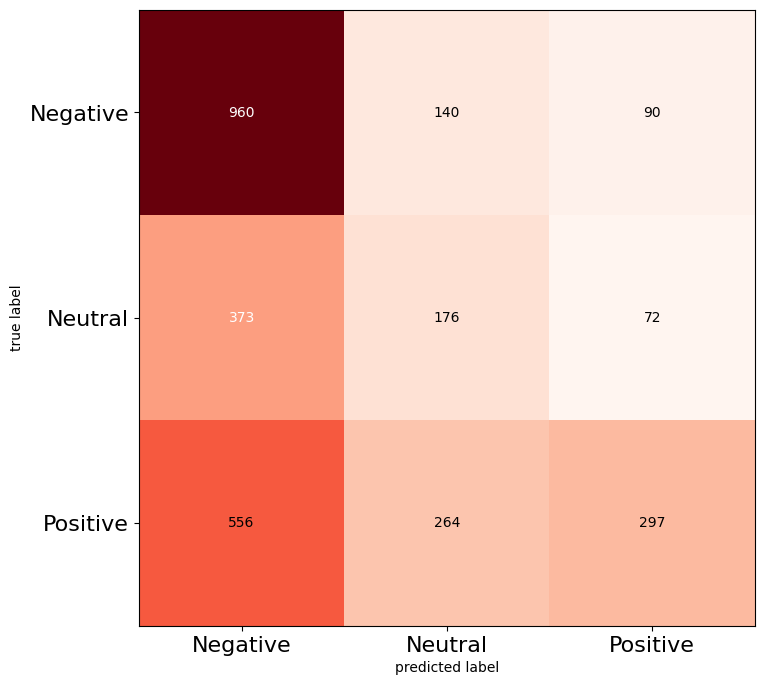

In [76]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['airline_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['airline_sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['airline_sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))
    print(classification_report(pred,test['airline_sentiment']))
    cm=confusion_matrix(pred , test['airline_sentiment'])
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
    plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
    plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
    plt.show()

# Training a model on positive tweet sentiment

In this next section I will train a model on positive tweet sentiment. I will do this by creating a subset of data that deals only with the compound score of positive tweets, that were classified previously. I will then run this against a resampled hourly time series to predict tweet sentiment. 

I will perform the dickey fuller test, plot autocorrelation and partial auto correlation to find my optimal parameters. I am doing this because these graphs are based on the dataset and should give me optimal parameters

In [77]:
df1.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,Date,sentiment,clean_tweet,Tweet_length,Compound_Scores
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,2015-02-24 19:35:52,1,virginamerica dhepburn said,3,0.0000
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,2015-02-24 19:15:59,1,virginamerica plus added commercials experienc...,6,0.0000
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,2015-02-24 19:15:48,1,virginamerica today must mean need take anothe...,8,0.0000
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,2015-02-24 19:15:36,0,virginamerica really aggressive blast obnoxiou...,11,-0.3306
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,2015-02-24 19:14:45,0,virginamerica really big bad thing,5,-0.5829


In [78]:
dfsentiment = df1.drop(["tweet_created","negativereason","sentiment","clean_tweet","tweet_id","text","Tweet_length","airline","name","retweet_count" ,"negativereason_confidence","airline_sentiment_confidence"], axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
dfsentiment.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,airline_sentiment,Date,Compound_Scores
0,neutral,2015-02-24 19:35:52,0.0000
1,positive,2015-02-24 19:15:59,0.0000
2,neutral,2015-02-24 19:15:48,0.0000
3,negative,2015-02-24 19:15:36,-0.3306
4,negative,2015-02-24 19:14:45,-0.5829


In [80]:
dfsentiment2 = dfsentiment.loc[df1["airline_sentiment"]=='positive']
dfsentiment2.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,airline_sentiment,Date,Compound_Scores
1,positive,2015-02-24 19:15:59,0.0000
6,positive,2015-02-24 19:13:57,0.4019
8,positive,2015-02-24 19:11:19,0.2732
9,positive,2015-02-24 18:53:27,0.7717
11,positive,2015-02-24 18:30:40,0.7269


In [82]:
dfsentiment3 = dfsentiment2.set_index(dfsentiment2["Date"])

senti = dfsentiment3.resample(rule='H').mean()

senti.fillna(senti.mean(numeric_only=True).round(1), inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-82-c762ae96ce22>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  senti = dfsentiment3.resample(rule='H').mean()


Below is the timeseries of positive tweet sentiments that I will use for the basis of my model. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Date'>

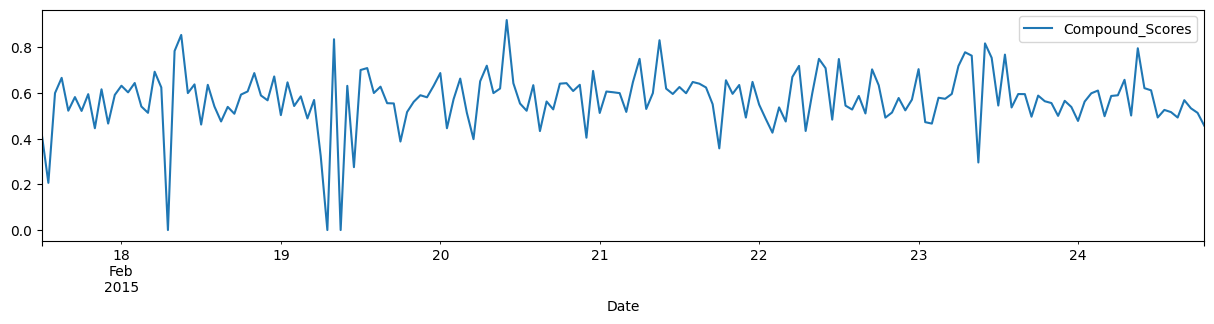

In [84]:
senti.resample(rule='H').mean().plot(y=["Compound_Scores"],figsize=(15,3))

In [85]:
senti.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Compound_Scores
Date,
2015-02-17 12:00:00,0.421500
2015-02-17 13:00:00,0.206800
2015-02-17 14:00:00,0.600000
2015-02-17 15:00:00,0.666800
2015-02-17 16:00:00,0.522931


In [86]:
senti.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(176, 1)

In [87]:
adfuller(senti["Compound_Scores"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-14.54654029550257,
 5.046074404592402e-27,
 0,
 175,
 {'1%': -3.4682803641749267,
  '5%': -2.8782017240816327,
  '10%': -2.5756525795918366},
 -197.3236950937374)

The dickey fuller test suggested the data was not stationary, so it was necessary to seek the d value. I have applied differencing up to 3 on the dataset to which of these is optimal. It looks as though 1 is sufficient as 2 misses out on most of the trends in the data and would possibly overfit the model.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


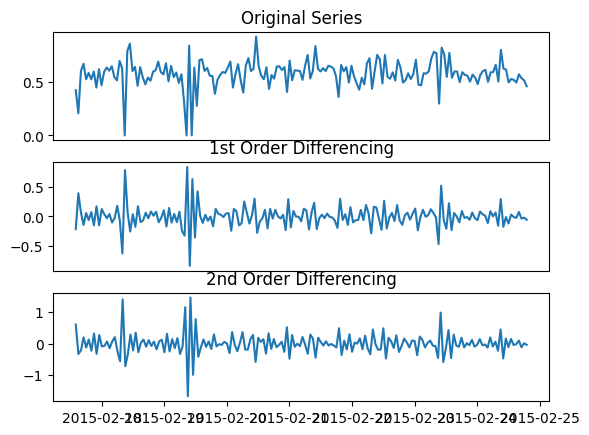

In [88]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(senti.Compound_Scores); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(senti.Compound_Scores.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(senti.Compound_Scores.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


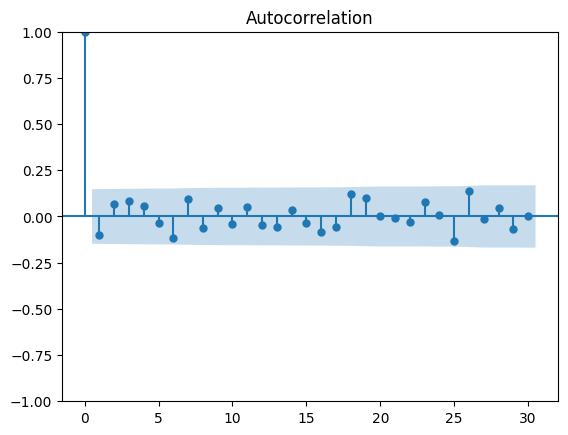

In [90]:
plot_acf(senti["Compound_Scores"], lags=30);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


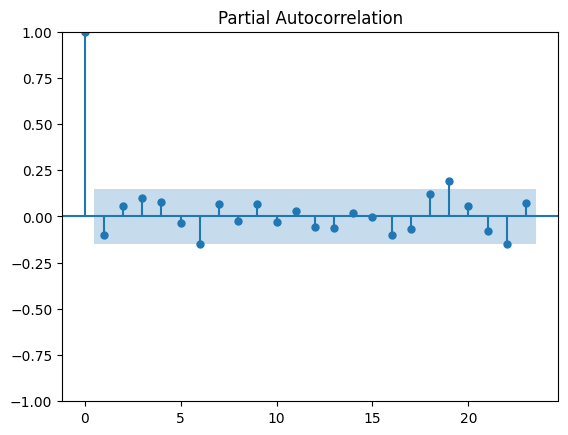

In [91]:
plot_pacf(senti["Compound_Scores"]);

Based on the results of auto and partial autocorrelation, as well as cycling through orders of differencing, I have selected the below parameters as I think they are optimal for this model. 

p=1, d=1, q=0

In [93]:
model = sm.ARIMA(senti["Compound_Scores"], order=(1, 1, 0)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Compound_Scores   No. Observations:                  176
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  76.892
Date:                Sat, 27 May 2023   AIC                           -149.785
Time:                        09:57:58   BIC                           -143.455
Sample:                    02-17-2015   HQIC                          -147.217
                         - 02-24-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5832      0.034    -16.917      0.000      -0.651      -0.516
sigma2         0.0243      0.002     15.807      0.000       0.021       0.027
===================================================================================
Ljung-Box (L1) (Q):                   9.34   Jarque-Bera (JB):               100.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
train = senti[:int((0.85)*len(senti))]
test = senti[int((0.85)*len(senti)):]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
start = len(train)
end = len(train) + len(test) -1
tmodel = model.predict(start=start, end=end).rename("ARIMA Predictions")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Results and conclusions

We can see the model performs very well. Picking up almost all the trends in the data. This accuracy would almost suggest possible overfitting due to the training data not being able to pick up all the possible values. This is a similar limitation that I came across during the one week time series forecast.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


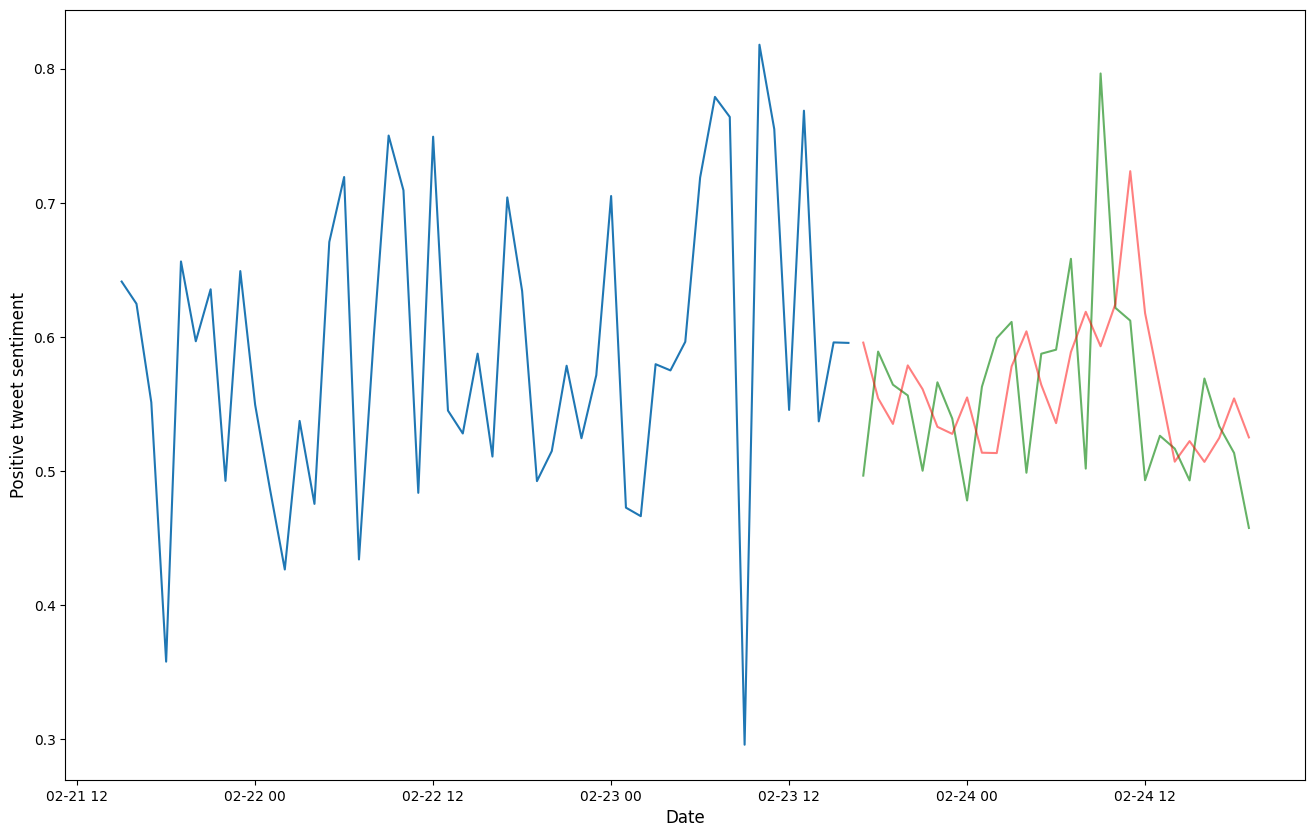

In [98]:
plt.figure(figsize = [16, 10])
plt.plot(train["Compound_Scores"].iloc[-50:])
plt.plot(test["Compound_Scores"], color="green", alpha=0.6)
plt.plot(tmodel, color="red", alpha=0.5,)

plt.xlabel("Date", fontsize = 12)
plt.ylabel("Positive tweet sentiment", fontsize = 12)

plt.show()


# Training a model on a topic of my choice. 

I will now train a time series model based on compound tweet sentiment score relating specifically to american airlines. I am doing this because it was the largest topic within the topic modeling results and so may yield interesting information that the company can use going forward. 

I will perform the same tests as the previous time series model to understand about this specific subset of data and fit an ARIMA model to perform a prediction. 

In [99]:
dfairline = df1.drop(["tweet_created","negativereason","sentiment","clean_tweet","tweet_id","text","Tweet_length","name","retweet_count" ,"negativereason_confidence","airline_sentiment_confidence"], axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
dfairline2 = dfairline.loc[df1["airline"]=='American']
dfairline2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,airline_sentiment,airline,Date,Compound_Scores
11879,negative,American,2015-02-24 19:44:31,-0.5423
11880,neutral,American,2015-02-24 19:43:32,0.0000
11881,negative,American,2015-02-24 19:43:05,0.4404
11882,negative,American,2015-02-24 19:43:05,0.6705
11883,negative,American,2015-02-24 19:41:02,0.2023


In [101]:
dfairline3 = dfairline2.set_index(dfairline2["Date"])

airline = dfairline3.resample(rule='H').mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-101-aa0178a2c6ad>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  airline = dfairline3.resample(rule='H').mean()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Date'>

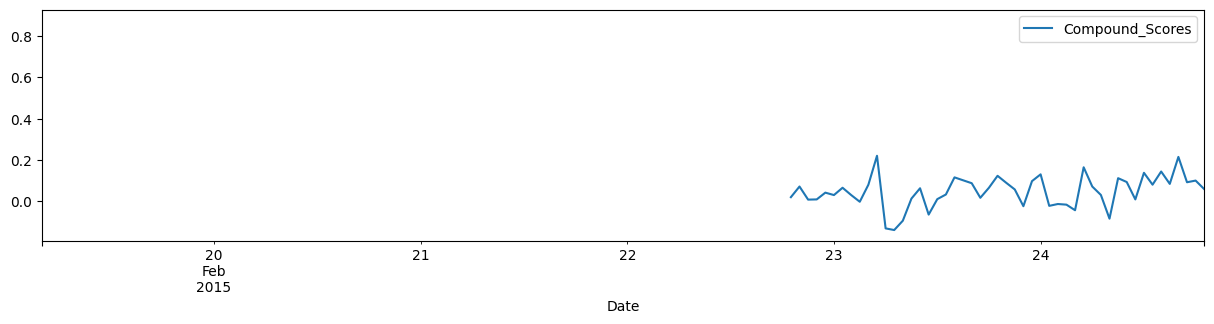

In [102]:
airline.resample(rule='H').mean().plot(y=["Compound_Scores"],figsize=(15,3))

In [108]:
airline.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Compound_Scores
Date,
2015-02-19 04:00:00,0.2263
2015-02-19 05:00:00,NaN
2015-02-19 06:00:00,NaN
2015-02-19 07:00:00,NaN
2015-02-19 08:00:00,NaN


In [132]:
airline.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(136, 1)

In [110]:
airlinefin = airline.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
airlinefin.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(53, 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Date'>

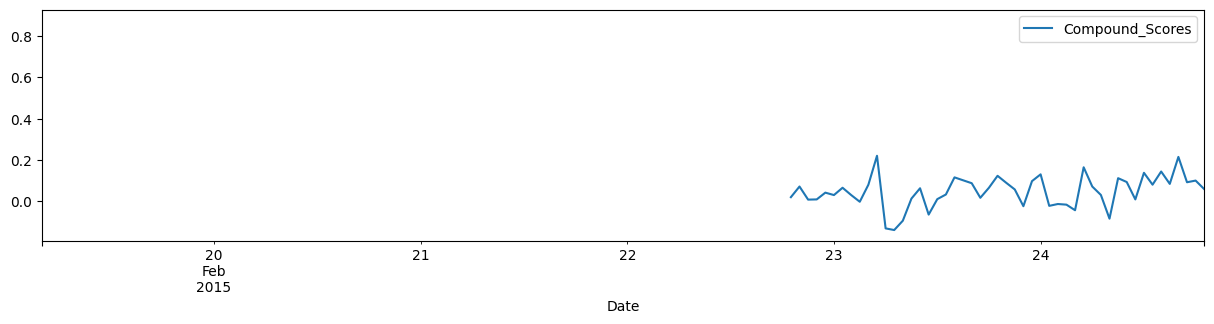

In [123]:
airlinefin.resample(rule='H').mean().plot(y=["Compound_Scores"],figsize=(15,3))

In [114]:
adfuller(airlinefin["Compound_Scores"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-4.209017434621885,
 0.0006361205382106544,
 0,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 -86.14666191442325)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


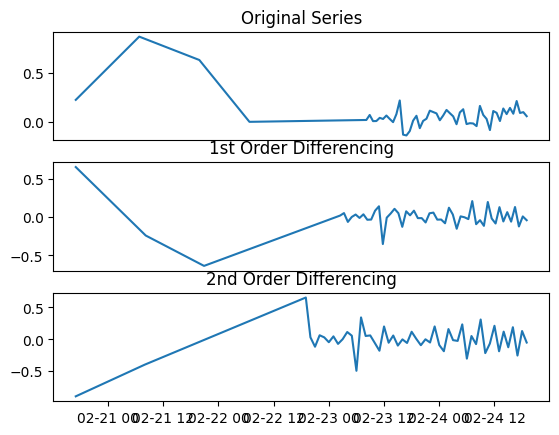

In [115]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(airlinefin.Compound_Scores); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(airlinefin.Compound_Scores.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(airlinefin.Compound_Scores.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


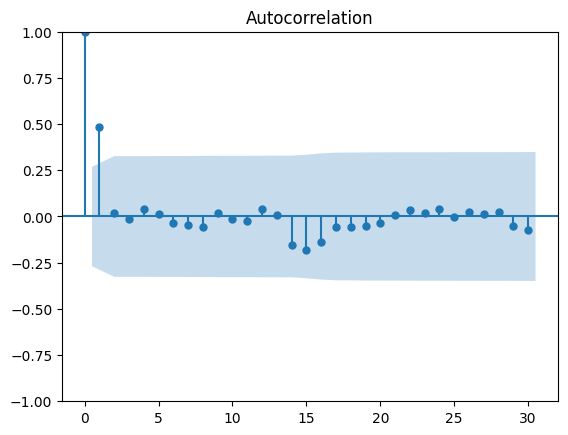

In [116]:
plot_acf(airlinefin["Compound_Scores"], lags=30);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


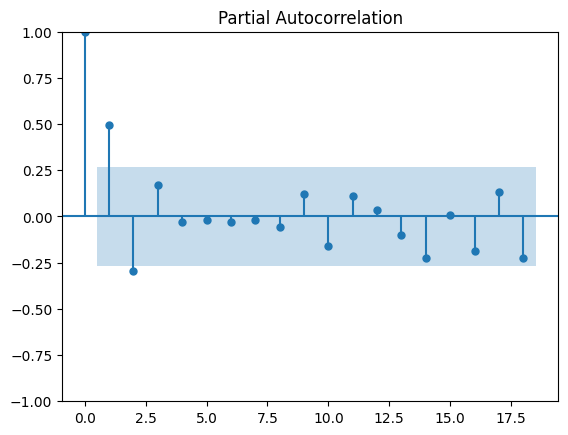

In [118]:
plot_pacf(airlinefin["Compound_Scores"]);

Though the results of the dickey fuller test showed a stationary dataset, for consistency I plotted out 3 orders of differencing as before. We can see that both auto and partial auto correlation graphs drop off at 2. Therefore I have chosen the parameters of p=2, d=0 and q=2 for this model. 

In [119]:
model = sm.ARIMA(airlinefin["Compound_Scores"], order=(2, 0, 2)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associ

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Compound_Scores   No. Observations:                   53
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  33.726
Date:                Sat, 27 May 2023   AIC                            -55.452
Time:                        10:11:32   BIC                            -43.630
Sample:                             0   HQIC                           -50.906
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.040      1.793      0.073      -0.007       0.151
ar.L1         -0.3052      0.422     -0.724      0.469      -1.132       0.521
ar.L2         -0.4169      0.233     -1.786      0.074      -0.874       0.041
ma.L1          1.0119      0.428      2.363      0.018       0.173       1.851
ma.L2          0.6326      0.257      2.461      0.014       0.129       1.136
sigma2         0.0161      0.003      5.676      0.000       0.011       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               276.29
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             2.20
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [127]:
train = airlinefin[:int((0.85)*len(airlinefin))]
test = airlinefin[int((0.85)*len(airlinefin)):]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
start = len(train)
end = len(train) + len(test) -1
tmodel = model.predict(start=start, end=end).rename("ARIMA Predictions")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can see that the model is picking up the trends in the data however the prediction is small. This is because in order to get this particular subset of data, I had to remove alot of entries and so was left with a very small dataset.This made the training and testing of the dataset difficult and possibly led to overfitting.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


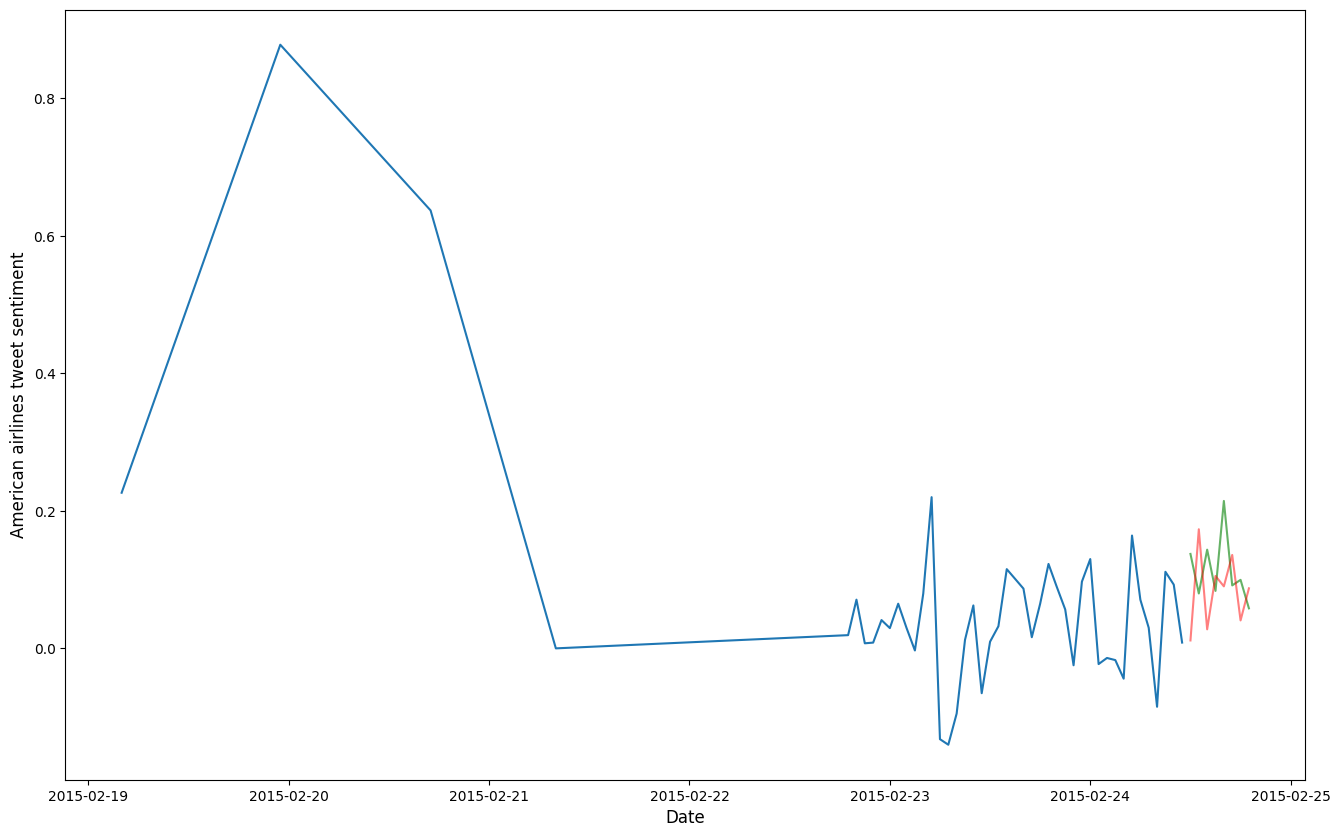

In [133]:
plt.figure(figsize = [16, 10])
plt.plot(train["Compound_Scores"].iloc[-50:])
plt.plot(test["Compound_Scores"], color="green", alpha=0.6)
plt.plot(tmodel, color="red", alpha=0.5,)

plt.xlabel("Date", fontsize = 12)
plt.ylabel("American airlines tweet sentiment", fontsize = 12)

plt.show()

#Results and conclusions

I have performed time series analysis and produced a forecast for one week of tweets. I have also performed topic modeling and sentiment analysis on the dataset to gain a better understanding of of the sentiment that is associated with tweets in the dataset. 

I feel that the main limitations with this dataset, especially in conducting the time series analysis, was the size of the dataset. The amount of data provided an interesting problem in which to remove outliers, would impact the integrity of the models, however to keep them in gave each model an inability to pick them up or overfit them. The main difference being that creating a one week forecast failed to pick up the outliers while making predictions showed overfitting. 

# References

Brownlee, J. (2020). 4 Types of Classification Tasks in Machine Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/types-of-classification-in-machine-learning/.

Frost, J. (2021). Autocorrelation and Partial Autocorrelation in Time Series Data. [online] Statistics By Jim. Available at: https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/.

levity.ai. (n.d.). What Is Topic Modeling? A Beginner’s Guide. [online] Available at: https://levity.ai/blog/what-is-topic-modeling#:~:text=Topic%20modeling%20is%20a%20type.

Verma, Y. (2021). Complete Guide To Dickey-Fuller Test In Time-Series Analysis. [online] Analytics India Magazine. Available at: https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/.

Verma, Y. (2022). Quick way to find p, d and q values for ARIMA. [online] Analytics India Magazine. Available at: https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/.